<a href="https://colab.research.google.com/github/rht6226/DL/blob/main/UCI_Mobile_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the preprocessed datasets



In [20]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [4]:
class UciMobileDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'uci.npz') as data:
            self.trainX = data['trainX']
            self.trainy = to_categorical(data['trainy'])
            self.testX = data['testX']
            self.testy = to_categorical(data['testy'])

    def summary(self):
        print("UCI Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))


In [5]:
uci = UciMobileDataset(filepath='/content/drive/My Drive/HAR Processed Data/UCI_HAR/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


# Training on 1D CNN Architecture


In [21]:
import keras
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [7]:
def get_1DCNN_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [8]:
# Summarising the model Architecture

model_1D_CNN = get_1DCNN_model(uci.trainX, uci.trainy, uci.testX, uci.testy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 64)           1792      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           4160      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 64)           20544     
_________________________________________________________________
dropout (Dropout)            (None, 122, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 61, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3904)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

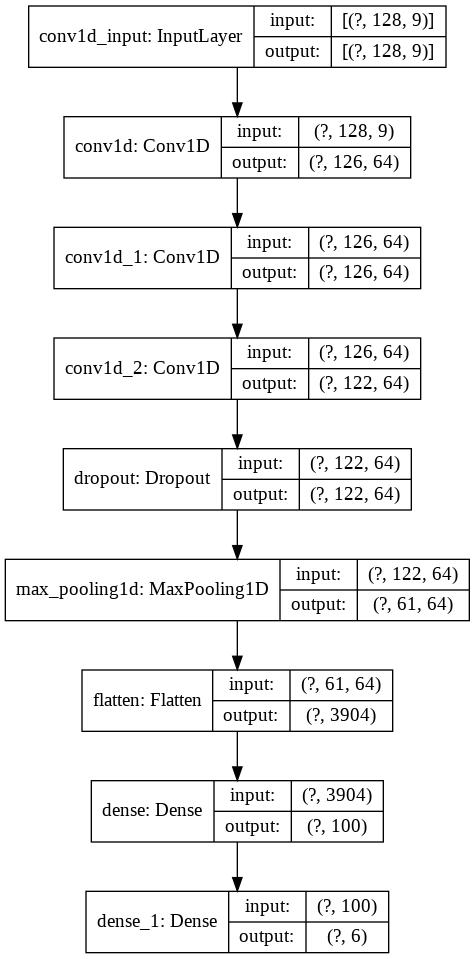

In [9]:
plot_model(model_1D_CNN, show_shapes=True, show_layer_names=True)

In [10]:
verbose, epochs, batch_size = 0, 10, 32
history_1D_CNN_UCI = model_1D_CNN.fit(uci.trainX, uci.trainy, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(uci.testX, uci.testy))

Epoch 1/10
230/230 [==============================] - 9s 39ms/step - loss: 0.3800 - accuracy: 0.8493 - val_loss: 0.2977 - val_accuracy: 0.8839
Epoch 2/10
230/230 [==============================] - 8s 37ms/step - loss: 0.1363 - accuracy: 0.9442 - val_loss: 0.2884 - val_accuracy: 0.8924
Epoch 3/10
230/230 [==============================] - 8s 37ms/step - loss: 0.1210 - accuracy: 0.9504 - val_loss: 0.3333 - val_accuracy: 0.9040
Epoch 4/10
230/230 [==============================] - 9s 37ms/step - loss: 0.1073 - accuracy: 0.9550 - val_loss: 0.3647 - val_accuracy: 0.9013
Epoch 5/10
230/230 [==============================] - 9s 37ms/step - loss: 0.0970 - accuracy: 0.9569 - val_loss: 0.3865 - val_accuracy: 0.8972
Epoch 6/10
230/230 [==============================] - 8s 37ms/step - loss: 0.0975 - accuracy: 0.9584 - val_loss: 0.4389 - val_accuracy: 0.8975
Epoch 7/10
230/230 [==============================] - 8s 37ms/step - loss: 0.1093 - accuracy: 0.9512 - val_loss: 0.7240 - val_accuracy: 0.8568

In [11]:
model_1D_CNN.save('/content/drive/My Drive/Colab Notebooks/Models/1DCNN_UCIHAR.h5')

In [12]:
_, accuracy = model_1D_CNN.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 1s 9ms/step - loss: 0.3443 - accuracy: 0.9141
0.9141499996185303


In [13]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

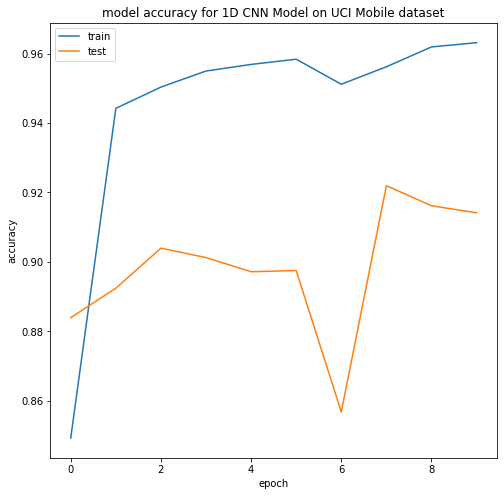

In [14]:
plot_model_accuracy("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

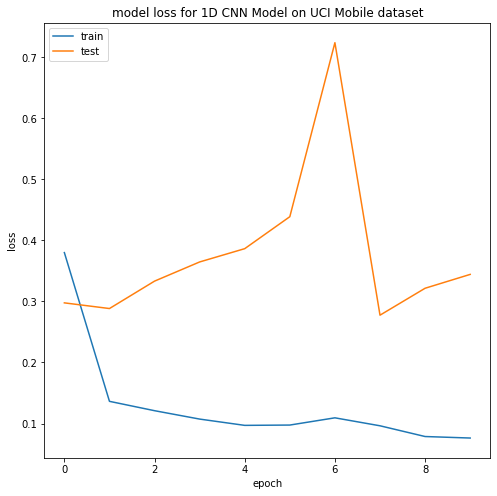

In [15]:
plot_model_loss("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

# Training on Inception Architecture

In [22]:
def Inception1D(input_layer, filter):
    # 1x1 Convolution
    conv_1x1 = Conv1D(filters=filter[0], kernel_size=1, activation='relu', padding='same')(input_layer)
    # 1x3 Convolution
    conv_1x3_reduce = Conv1D(filters=filter[1][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x3 = Conv1D(filters=filter[1][1], kernel_size=3, activation='relu', padding='same')(conv_1x3_reduce)
    # 1x5 Convolution
    conv_1x5_reduce = Conv1D(filters=filter[2][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x5 = Conv1D(filters=filter[2][1], kernel_size=5, activation='relu', padding='same')(conv_1x5_reduce)
    # 1x3 MaxPooling
    max_1x3 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_layer)
    max_conv_1x1 = Conv1D(filters=filter[3], kernel_size=1, activation='relu', padding='same')(max_1x3)
    # Concat
    output = Concatenate()([conv_1x1, conv_1x3, conv_1x5, max_conv_1x1])
    
    
    return output

In [23]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

In [24]:
def get_inception_model(input_shape, output_shape):
    ip_layer = Input(shape=input_shape)
    x = Inception1D(input_layer=ip_layer, filter=[32, (24, 64), (16, 32), 24])
    x = Inception1D(input_layer=x, filter=[48, (36, 64), (24, 48), 32])
    x = Inception1D(input_layer=x, filter=[32, (36, 64), (48, 72), 48])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Inception1D(x, [32, (24, 64), (24, 64), 24])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Flatten()(x)
    x = Dense(output_shape, activation='softmax')(x)

    model = Model(ip_layer, x, name='inception_HAR')

    return model

In [25]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

model = get_inception_model(input_shape, output_shape)
model.summary()

Model: "inception_HAR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 128, 24)      240         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 128, 16)      160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 128, 9)       0           input_2[0][0]                    
______________________________________________________________________________________

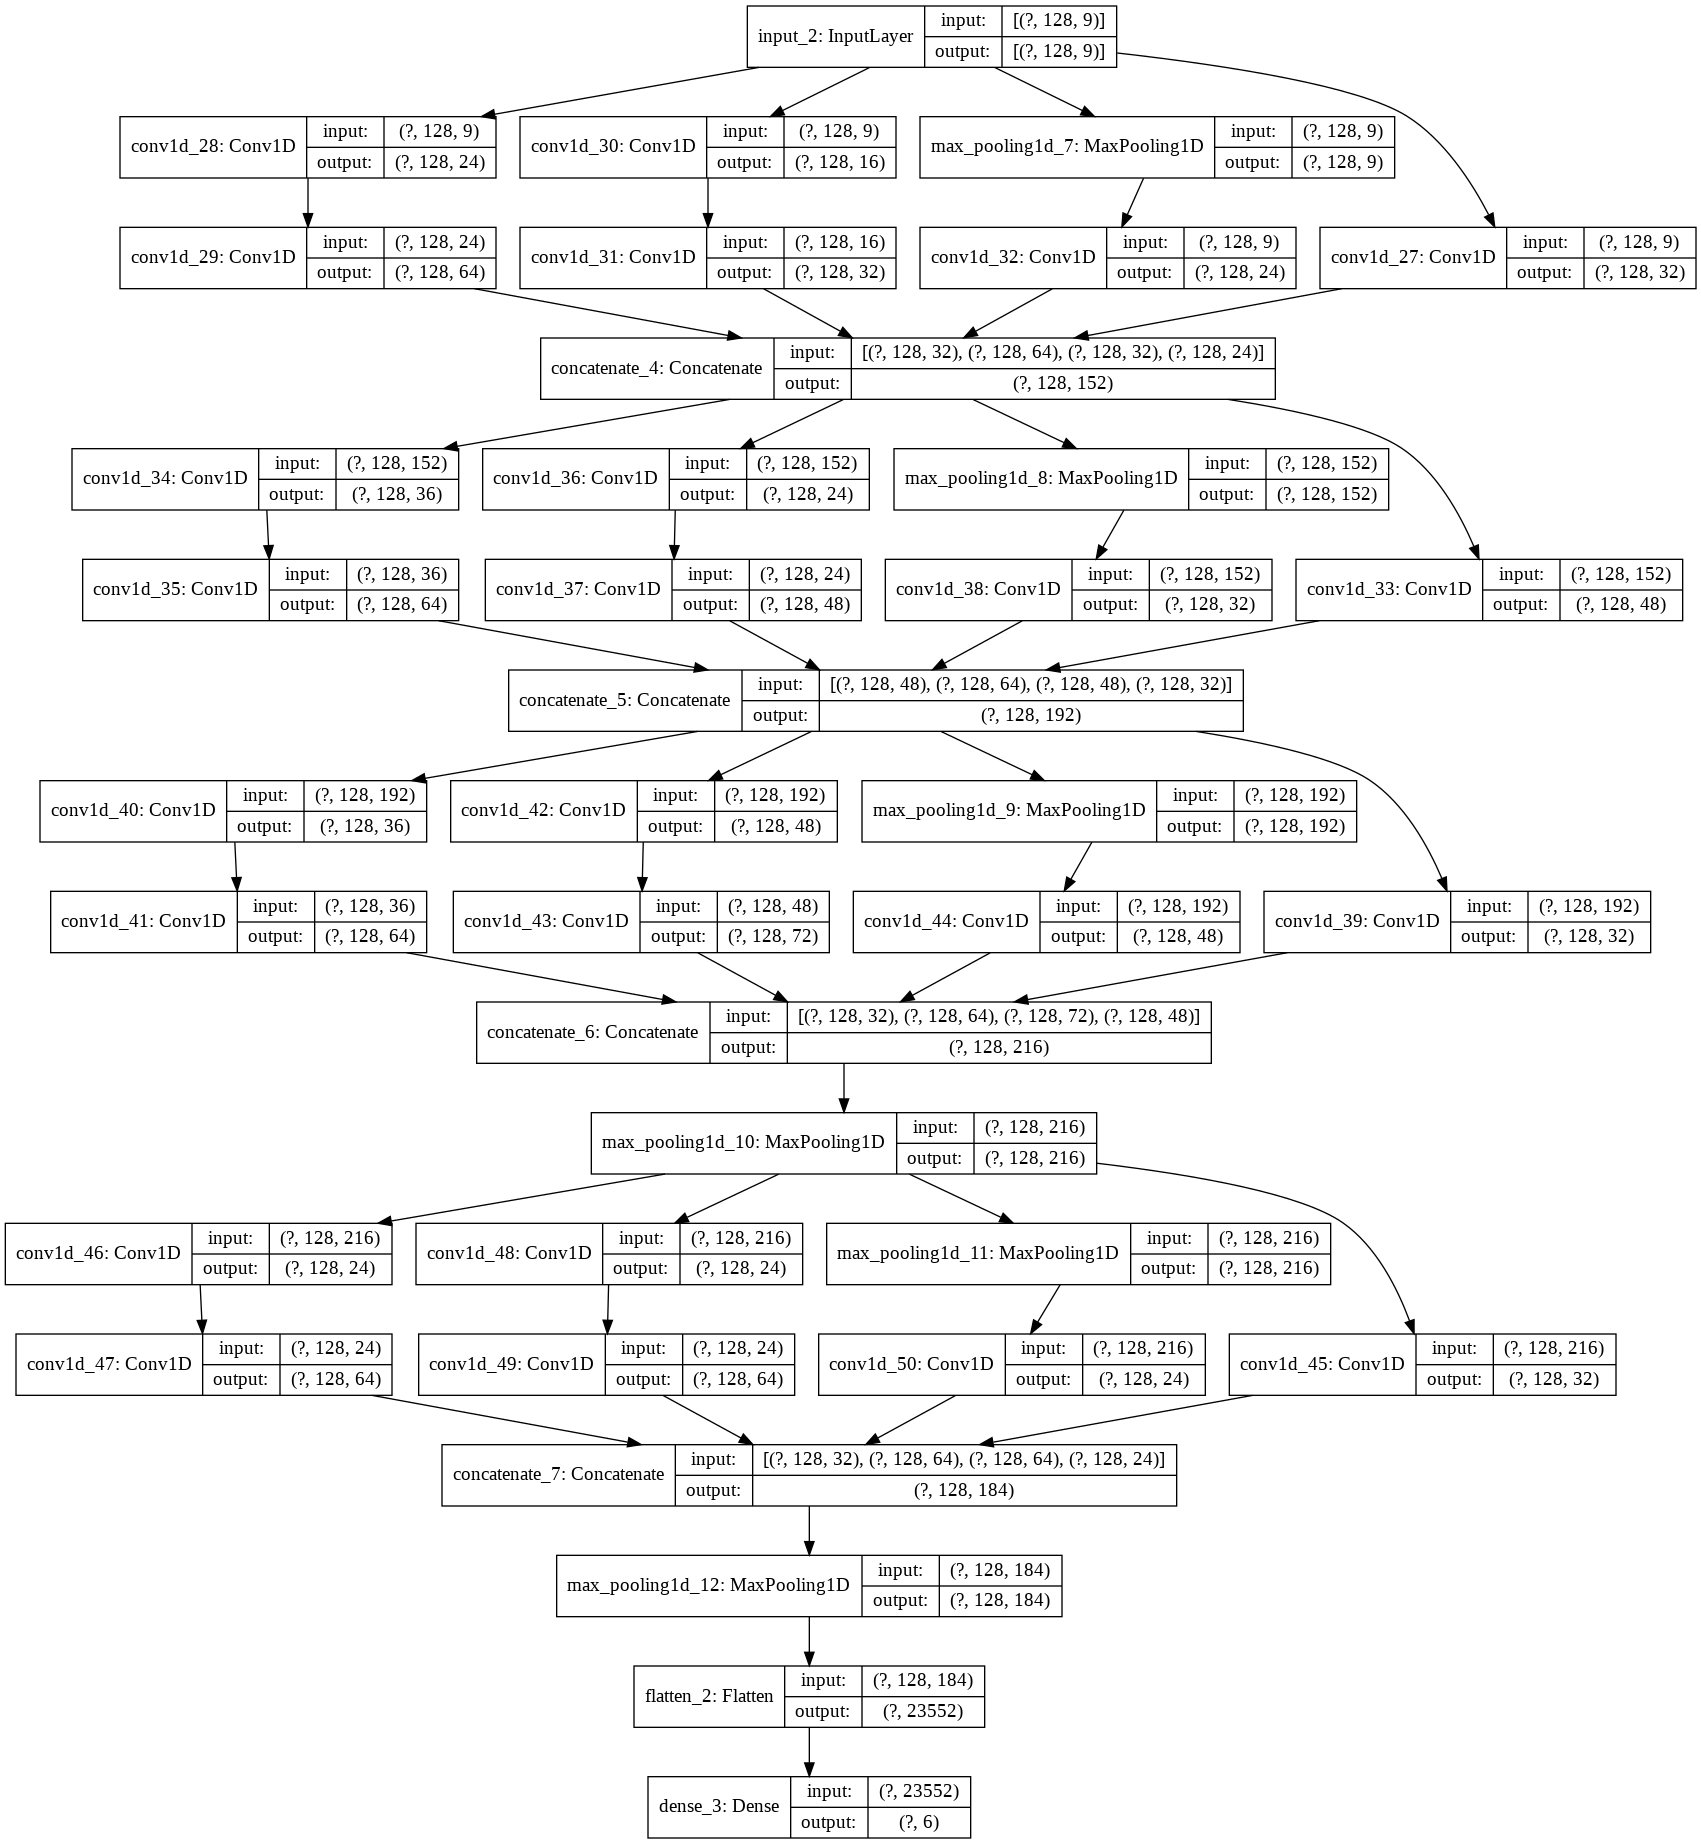

In [26]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = model.fit(x=uci.trainX, y=uci.trainy, validation_data=(uci.testX, uci.testy), verbose=1, batch_size=32, epochs=8)

Epoch 1/8
230/230 [==============================] - 50s 215ms/step - loss: 0.3056 - accuracy: 0.8753 - val_loss: 0.4511 - val_accuracy: 0.8802
Epoch 2/8
230/230 [==============================] - 47s 205ms/step - loss: 0.1286 - accuracy: 0.9484 - val_loss: 0.4026 - val_accuracy: 0.8897
Epoch 3/8
230/230 [==============================] - 56s 245ms/step - loss: 0.1157 - accuracy: 0.9493 - val_loss: 0.4071 - val_accuracy: 0.9114
Epoch 4/8
230/230 [==============================] - 52s 224ms/step - loss: 0.1236 - accuracy: 0.9460 - val_loss: 0.4029 - val_accuracy: 0.9121
Epoch 5/8
230/230 [==============================] - 50s 220ms/step - loss: 0.1190 - accuracy: 0.9486 - val_loss: 0.3572 - val_accuracy: 0.9121
Epoch 6/8
230/230 [==============================] - 51s 221ms/step - loss: 0.0999 - accuracy: 0.9535 - val_loss: 0.7512 - val_accuracy: 0.8799
Epoch 7/8
230/230 [==============================] - 50s 217ms/step - loss: 0.0888 - accuracy: 0.9607 - val_loss: 0.4409 - val_accuracy:

In [29]:
model_1D_CNN.save('/content/drive/My Drive/Colab Notebooks/Models/inception_UCIHAR.h5')

In [30]:
_, accuracy = model.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 3s 35ms/step - loss: 0.5259 - accuracy: 0.9043
0.9043094515800476


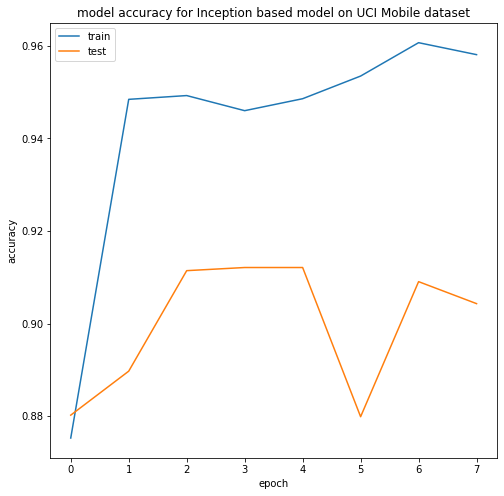

In [31]:
plot_model_accuracy("Inception based model on UCI Mobile dataset", history=history)

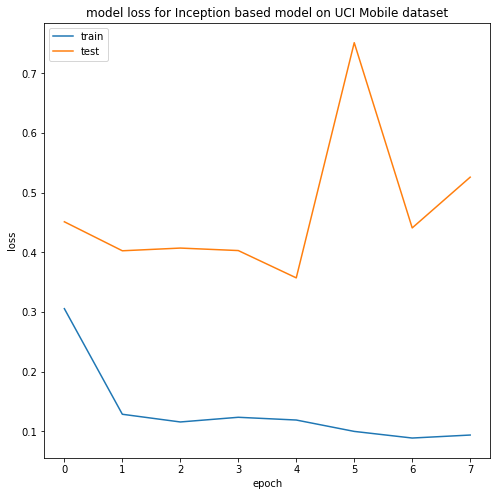

In [32]:
plot_model_loss("Inception based model on UCI Mobile dataset", history=history)

# Plotting Confusion Matrices



In [33]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [34]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


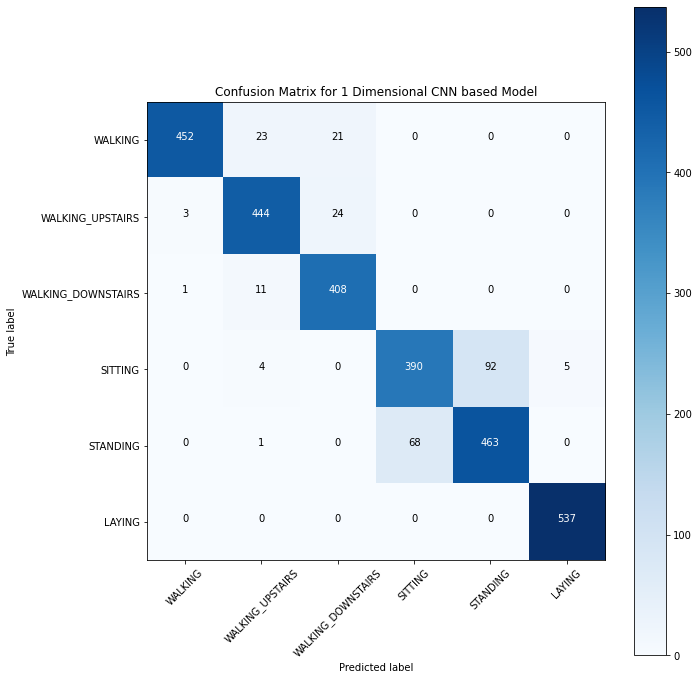

In [35]:
# CNN Based Network
predictedY = model_1D_CNN.predict(uci.testX)
cm_plot_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for 1 Dimensional CNN based Model')

Confusion matrix, without normalization


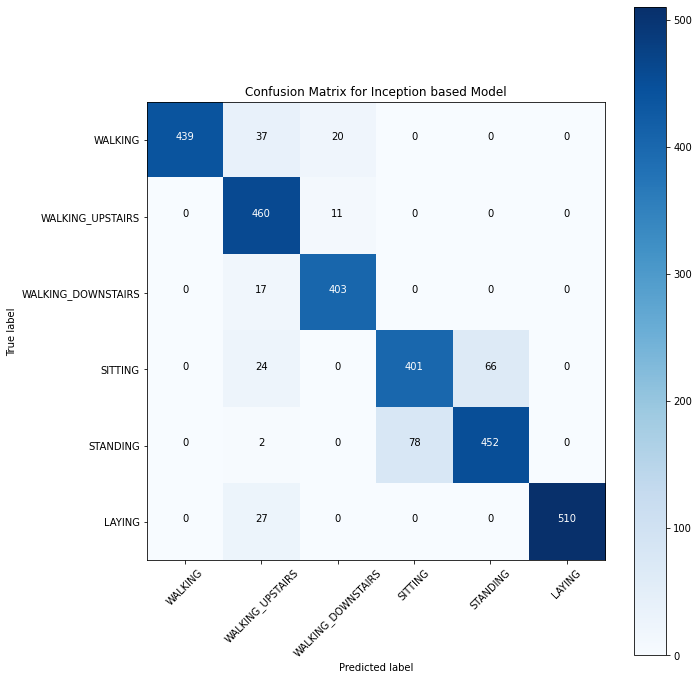

In [36]:
# Inception Based Network
predictedY = model.predict(uci.testX)
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception based Model')

Confusion matrix, without normalization


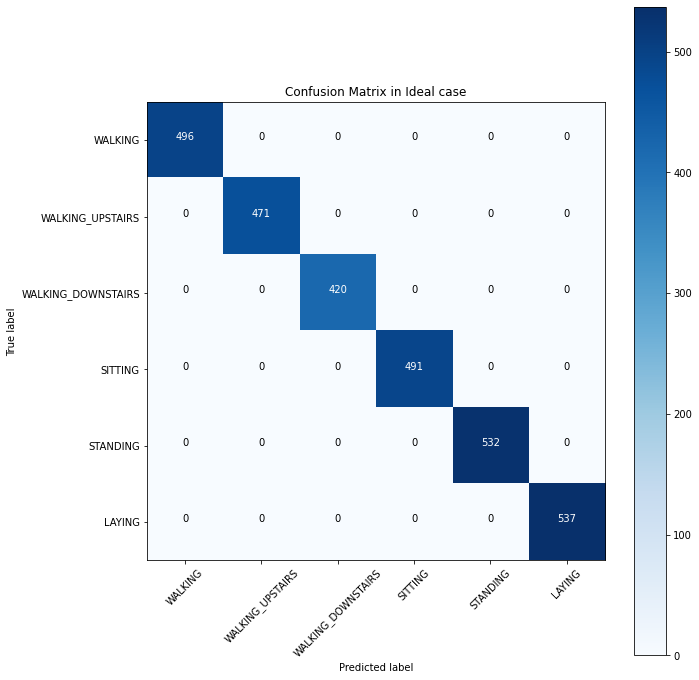

In [37]:
plot_cm(uci.testy, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix in Ideal case')

# Classification Reports

In [38]:
from sklearn.metrics import classification_report

In [40]:
# 1D CNN based Model
predictedY = model_1D_CNN.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           WALKING       0.99      0.91      0.95       496
  WALKING_UPSTAIRS       0.92      0.94      0.93       471
WALKING_DOWNSTAIRS       0.90      0.97      0.93       420
           SITTING       0.85      0.79      0.82       491
          STANDING       0.83      0.87      0.85       532
            LAYING       0.99      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.92      0.91      0.91      2947



In [41]:
# Inception Based Model

predictedY = model.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           WALKING       1.00      0.89      0.94       496
  WALKING_UPSTAIRS       0.81      0.98      0.89       471
WALKING_DOWNSTAIRS       0.93      0.96      0.94       420
           SITTING       0.84      0.82      0.83       491
          STANDING       0.87      0.85      0.86       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.90      0.90      2947

